In [1]:
import os
import multiprocessing

from json import loads

# from time import sleep
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import kblab 
import math
from pandas.core.frame import DataFrame
from tqdm import tqdm
from urllib3.util import Retry
from urllib3 import PoolManager, make_headers
from kblab import Archive
import regex as re
from itertools import product
from transformers import AutoModel,pipeline
kblab.VERIFY_CA=False

/home/tmpuser/code/Exjobb-main/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-04 17:14:49.009683: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 17:14:49.072289: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 17:14:50.281714: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
years = range(1970, 1980)

In [3]:
df: DataFrame = pd.read_feather("data/all_metadata_1970s.feather")

In [4]:
df

,created,year,edition,issue,title,dark_id
0,1971-07-14,1971,0,186,AFTONBLADET,dark-1024
1,1971-07-05,1971,0,177,AFTONBLADET,dark-1023
2,1975-08-26,1975,0,229,AFTONBLADET,dark-102141
3,1975-08-30,1975,0,233,AFTONBLADET,dark-102140
4,1974-01-09,1974,0,8,AFTONBLADET,dark-102131
...,...,...,...,...,...,...
10744,1979-12-31,1979,11171,354,DAGENS NYHETER,dark-4212913
10745,1979-12-28,1979,11171,351,DAGENS NYHETER,dark-4212910
10746,1979-12-30,1979,11171,353,DAGENS NYHETER,dark-4212845
10747,1979-12-29,1979,11171,352,DAGENS NYHETER,dark-4212901


In [5]:
df_content: DataFrame = pd.read_feather("data/df_content_1970s.feather")

In [6]:
df_content
df_numpy = np.array(df_content)
df_content

,content,dark_id,title,created
0,En M/2 miljon han inte ta fel - dom tar Af ton...,dark-1024,AFTONBLADET,1971-07-14
1,kdöde drigsemeste Un 1/2 miljon kan inte ta ...,dark-1023,AFTONBLADET,1971-07-05
2,om sanningen ska fränt on bladet J Tel 08 ...,dark-102141,AFTONBLADET,1975-08-26
3,Aftonbladet behövs om sanningen ska fram r ...,dark-102140,AFTONBLADET,1975-08-30
4,Tel 08/22 62 00 e onsdag i Aftonbladet Allan...,dark-102131,AFTONBLADET,1974-01-09
...,...,...,...,...
10744,Bort med trupperna från Afghanistan Moskva få...,dark-4212913,DAGENS NYHETER,1979-12-31
10745,Will Fredagen den 28 december 1979 VARDAGAR...,dark-4212910,DAGENS NYHETER,1979-12-28
10746,DAGENS NYHETER. SÖNDAG Söndagen den 30 decemb...,dark-4212845,DAGENS NYHETER,1979-12-30
10747,mmm \i heter. V&drei Vecka 52 Lördagen den ...,dark-4212901,DAGENS NYHETER,1979-12-29


In [7]:

regex = r"\p{L}+"
def tokenize(text):
  return re.finditer(regex, text.lower())

In [8]:
def text_to_idx(words):
  wordCount = 0
  wordPos = {}
  for token in words:
    wordCount+=1
    word = token.group()
    pos = token.span()[0]
    if word in wordPos.keys():
      wordPos[word].append(pos)
    else:
      wordPos[word] = [pos]
  return wordPos, wordCount

In [9]:
tokens = tokenize("Men hallå där!")
idx, wordCount = text_to_idx(tokens)
print(wordCount)
idx.keys()

3


dict_keys(['men', 'hallå', 'där'])

In [10]:
def getDeclension(word):
  if word[-2:] == "tt" or word[-2:] == "st":
    root = word[:-1]
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-2:] == "rt":
    root = word[:-1]
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-1:] == "t":
    root = word[:-1]
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  if word[-3:] == "gam":
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-1:] == "m":
    return [word, f"{word}men", f"{word}mar", f"{word}marna"]
  if word[-2:] == "ss":
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  if word[-1:] == "a":
    root = word[:-1]
    return [word, f"{root}an", f"{root}or", f"{root}orna"]
  if word[-2:] == "yr":
    root = word[:-2]
    return [word, f"{word}en", f"{root}rar", f"{root}rarna"]
  if word[-3:] == "ger":
    root = word[:-2]
    return [word, f"{root}ern", f"{root}rar", f"{root}rarna"]
  if word[-1:] == "r" and (not word[-2:] == "är"):
    root = word[:-1]
    return [word, f"{word}et", f"{word}", f"{word}en"]
  if word[-1:] == "d":
    root = word[:-3]
    return [word, f"{word}et", f"{root}änder", f"{root}änderna"]
  if word[-3:] == "are" and (not word[-5:] == "stare"):
    root = word[:-1]
    return [word, f"{root}en", f"{root}e", f"{root}na"]
  if word[-2:] == "re":
    root = word[:-1]
    return [word, f"{root}en", f"{root}ar", f"{root}arna"]
  if word[-1:] == "e":
    root = word[:-1]
    return [word, f"{root}en", f"{root}ar", f"{root}arna"]
  if word[-4:] == "rell":
    root = word[:-2] 
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  if word[-2:] == "ll":
    root = word[:-2] 
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-2:] == "yl" or word[-3:] == "nal":
    root = word[:-2] 
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  if word[-3:] == "gal":
    root = word[:-2] 
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-1:] == "l":
    root = word[:-2] 
    return [word, f"{root}eln", f"{root}lar", f"{root}larna"]
  if word[-2:] == "ag":
    root = word 
    return [word, f"{root}et", f"{root}", f"{root}en"]
  if word[-1:] == "g":
    root = word 
    return [word, f"{root}en", f"{root}ar", f"{root}arna"]
  if word[-2:] == "um":
    root = word[:-2] 
    return [word, f"{root}en", f"{root}nar", f"{root}narna"]
  if word[-2:] == "en":
    root = word[:-2] 
    return [word, f"{root}nen", f"{root}er", f"{root}erna"]
  if word[-2:] == "an":
    root = word[:-2] 
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  if word[-2:] == "ur" or word[-2:] == "är":
    root = word[:-2] 
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  if word[-2:] == "nd":
    root = word[:-3]
    return [word, f"{word}en", f"{root}änder", f"{word}änderna"]
  if word[-1:] == "ö":
    return [word, f"{word}n", f"{word}ar", f"{word}arna"]
  if word[-2:] == "es":
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-2:] == "rk" or word[-2:] == "nk":
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-2:] == "ök" or word[-2:] == "åk" or word[-2:] == "lk" or word[-2:] == "ck":
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-1:] == "k":
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  if word[-1:] == "o":
    return [word, f"{word}n", f"{word}er", f"{word}rna"]
  if word[-1:] == "s" and (not word[-2:] == "is" or not word[-2] == "es"):
    return [word, f"{word}et", f"{word}", f"{word}en"]
  else:
    root = word
    return [word, f"{root}en", f"{root}ar", f"{root}arna"]


In [11]:
getDeclension("kardinal")

['kardinal', 'kardinalen', 'kardinaler', 'kardinalerna']

In [12]:
birds = pd.read_csv("birds2.csv", header=0)
natureTypes = pd.read_csv("naturtyper.csv", header=0)
wordChecklist = natureTypes.copy()
natureTypes.iloc[0]["naturtyp"]
birds

,namn
0,fågel
1,andfågel
2,gås
3,svan
4,brantagås
...,...
1258,sjöfågel
1259,tropikflyttare
1260,storkartade fågel
1261,doppingfågel


In [13]:


def addWords(word, onlyDeclension = True): 
    global wordChecklist
    if onlyDeclension:
        wordDec = getDeclension(word)[1:]
        wordDecFrame = pd.DataFrame([wordDec[0],wordDec[1],wordDec[2]], columns=["naturtyp"])
    else:
        wordDec = getDeclension(word)
        wordDecFrame = pd.DataFrame([wordDec[0],wordDec[1],wordDec[2],wordDec[3]], columns=["naturtyp"])
    wordChecklist = pd.concat([wordChecklist,wordDecFrame])


In [14]:

natureTypes["naturtyp"].apply(lambda x: addWords(x, onlyDeclension=False))
print(wordChecklist)


                        naturtyp
0                       sandbank
1                      estuarium
2                     sandbotten
3                      lerbotten
4   blottade ler- och sandbotten
..                           ...
3                svämlövskogarna
0                svämädellövskog
1              svämädellövskogen
2              svämädellövskogar
3            svämädellövskogarna

[610 rows x 1 columns]


In [15]:
wordChecklistList = wordChecklist["naturtyp"].tolist()
print(wordChecklistList)

['sandbank', 'estuarium', 'sandbotten', 'lerbotten', 'blottade ler- och sandbotten', 'lagun', 'vik', 'sund', 'rev', 'bubbelstruktur', 'driftvall', 'stenvall ', 'grusvall', 'havsklippa', 'strand', 'glasörtstrand', 'salta strandäng', 'ö', 'åsö', 'skär', 'strandäng', 'smala östersjövik', 'dyn', 'fördyn', 'vita dyn', 'grå dyn', 'risdyner', 'sandvidedyn', 'trädklädda dyn', 'dynvåtmark', 'hed', 'rissandhed', 'grässandhedar', 'sjö', 'slättssjö', 'näringsfattiga slättssjöar', 'ävjestrandsjö', 'kransalgssjö', 'näringsrika sjö', 'näringsrik sjö', 'naturligt näringsrika sjö', 'myrsjö', 'vattendrag', 'större vattendrag', 'alpina vattendrag', 'mindre vattendrag', 'fukthed', 'torra hed', 'alpina rished', 'alpina videbuskmark', 'enbuskmark', 'berghäll', 'basiska berghäll', 'sandstäpp', 'mark', 'gräsmark', 'silikatgräsmark', 'alpina silikatgräsmark', 'alpina kalkgräsmark', 'kalkgräsmark', 'stagg-gräsmark', 'alv', 'älv', 'äng', 'fuktäng', 'högörtäng', 'svämäng', 'lågland', 'slåtteräng', 'slåtterängar i

In [16]:
from transformers import AutoModel,pipeline

ner = pipeline('ner', model='KB/bert-base-swedish-cased-ner', tokenizer='KB/bert-base-swedish-cased-ner')
pos = pipeline("token-classification", model="KBLab/bert-base-swedish-cased-pos", tokenizer="KBLab/bert-base-swedish-cased-pos")



Some weights of the model checkpoint at KB/bert-base-swedish-cased-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at KBLab/bert-base-swedish-cased-pos were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with anoth

In [17]:
def getVerbs(text):
    posText = pos(text)
    l = []
    for token in posText:
        try:
            if token['word'].startswith('##'):
                l[-1]['word'] += token['word'][2:]
            else:
                l += [ token ]
        except:
            print(f"failed with {token}")
    return [x["word"] for x in list(filter(lambda d: d['entity'] == "VB", l))]

In [18]:
def getNamed(text):
    interestingTags = ["PRS", "LOC", "ORG", "OBJ"]
    posText = ner(text)
    l = []
    for token in posText:
        try:
            if token['word'].startswith('##'):
                l[-1]['word'] += token['word'][2:]
            else:
                l += [ token ]
        except:
            print(f"failed with {token}")
    return [x["word"] for x in list(filter(lambda d: d['entity'] in interestingTags, l))]    

In [16]:

master_index = {}
yearCounts = {}

for y in years:
    yearCounts.update({str(y):0})
totalCount = 0
tmp = 0

def addToIndex(row):
    global master_index
    tokens = tokenize(row["content"])
    idx, wordCount = text_to_idx(tokens)
    year = row["created"][:4]
    yearCounts[year] += wordCount
    for word in idx.keys():
        #if word in wordChecklist["svenskt namn"].values:
            if word in master_index:
                master_index[word][row["dark_id"], year] = idx[word]
            else:
                master_index[word] = {(row["dark_id"], year):idx[word]}
        


In [19]:
len(master_index)

11154031

In [18]:
df_content.apply(lambda row: addToIndex(row), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
10744    None
10745    None
10746    None
10747    None
10748    None
Length: 10749, dtype: object

In [20]:
def counter(word):
  master_index_bird = master_index[word]
  count = {}

  for y in years:
    count.update({str(y): {"freq":0, "count":0, "prob":0}})
  for a,b in master_index_bird:
    if b in count:
      count[b]["count"] += 1
    else:
      count[b]["count"] = 1
  for y in years:
    try:
      count[str(y)]["freq"] = count[str(y)]["count"]/yearCounts[str(y)]*100000
      count[str(y)]["prob"] = count[str(y)]["count"]/yearCounts[str(y)]
    except:
      count[str(y)]["freq"] = 0.0
  return count


In [21]:
counter("fågel")

{'1970': {'freq': 0.6632386081469978,
  'count': 577,
  'prob': 6.632386081469978e-06},
 '1971': {'freq': 0.6876926326110233,
  'count': 519,
  'prob': 6.876926326110233e-06},
 '1972': {'freq': 0.6724201498782651,
  'count': 514,
  'prob': 6.724201498782652e-06},
 '1973': {'freq': 0.6181218847016748,
  'count': 494,
  'prob': 6.181218847016748e-06},
 '1974': {'freq': 0.5536479226593557,
  'count': 449,
  'prob': 5.536479226593557e-06},
 '1975': {'freq': 0.5475024507623378,
  'count': 457,
  'prob': 5.475024507623378e-06},
 '1976': {'freq': 0.7178407265656898,
  'count': 606,
  'prob': 7.178407265656897e-06},
 '1977': {'freq': 0.70505971379219, 'count': 577, 'prob': 7.0505971379219e-06},
 '1978': {'freq': 0.7277796283285421,
  'count': 572,
  'prob': 7.2777962832854215e-06},
 '1979': {'freq': 0.7313963384247417,
  'count': 663,
  'prob': 7.313963384247417e-06}}

In [22]:
sentiment = pipeline("text-classification", model="KBLab/robust-swedish-sentiment-multiclass")


In [23]:
def getWordCooccurenceAndSentiment(word):
  yearsString = [str(y) for y in years]
  master_index_bird = master_index[word]
  sentimentByYear = {}
  global df_numpy
  cooccurence = {}
  for y in years:
    cooccurence.update({str(y):{}})
    sentimentByYear.update({str(y):[]})
  for issue, year in master_index_bird:
    rows, cols = np.where(df_numpy == issue)
    textBlock = df_numpy[rows][0][0].lower().replace(",", "")
    n = 5
    lhs, bird, rhs = textBlock.partition(word)
    window = lhs.split()[-n:] + rhs.split()[:n]
    sentimentWindow = " ".join(lhs.split()[-n:] + [bird] + rhs.split()[:n])
    textSentiment = sentiment(sentimentWindow)[0]["label"]
    sentimentByYear[year].append(textSentiment)
    birdWords = list(filter(None, window))
    #verbs = getVerbs(" ".join(birdWords))
    #named = getNamed(tmp)
    #natureWords = [k for k in birdWords if k in wordChecklistList]
    #interestingWords = verbs + natureWords
    #print(f"all: {birdWords}")
    #print(f"verbs {verbs}")
    #print(f"nature: {natureWords}")
    for bWord in birdWords:
      if bWord == word or bWord in yearsString:
        continue
      if bWord in cooccurence[year]:
        cooccurence[year][bWord] += 1
      else:
        cooccurence[year][bWord] = 1
      #print(f"checking {bWord}")    
  return cooccurence, sentimentByYear

In [24]:
def sortCooccurence(a):
  return sorted(a.items(), key=lambda x:x[1], reverse=True)

In [25]:
def mergeCounts(c1, c2):
  tmp = {}
  for y in years:
    tmp[str(y)] = {"freq": c1[str(y)]["freq"] + c2[str(y)]["freq"], "count": c1[str(y)]["count"] + c2[str(y)]["count"], "prob": c1[str(y)]["prob"] + c2[str(y)]["prob"]}
  return tmp


In [26]:
def mergeCoocs(c1, c2):
  tmp = {}
  for y in years:
    tmp[str(y)] = {k: (c1[str(y)].get(k, 0) + c2[str(y)].get(k, 0)) for k in set(c1[str(y)]) | set(c2[str(y)])}
  return tmp

In [27]:
def mergeSentiment(s1,s2):
    tmp = {}
    for y in years:
        tmp1 = s1[str(y)]
        tmp2 = s2[str(y)]
        tmp[str(y)] = tmp1+tmp2
    return tmp

In [28]:
birds

,namn
0,fågel
1,andfågel
2,gås
3,svan
4,brantagås
...,...
1258,sjöfågel
1259,tropikflyttare
1260,storkartade fågel
1261,doppingfågel


In [30]:

frequency = {}
cooccurenceMatrix = {}

for i, bird in birds.iterrows():
  specificbird = bird["namn"]
  birds_dec = getDeclension(specificbird)
  for bd in birds_dec:
    try:
      bc = counter(bd)
      if bird[0] in frequency:
        freq = frequency[specificbird]
      else:
        freq = {}
        for y in years:
          freq.update({str(y):{"freq":0, "count":0, "prob":0}})
      frequency[specificbird] = mergeCounts(bc, freq)
    except:
      "lmao"

/tmp/ipykernel_524026/3438062497.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if bird[0] in frequency:


In [33]:
frequency.keys()
dataFreq = {}
dataCount = {}

for b in frequency.keys():
    dataFreq.update({b: [frequency[b][x]["freq"] for x in frequency[b]]})
    dataCount.update({b: [frequency[b][x]["count"] for x in frequency[b]]})




In [34]:
dfFreq = pd.DataFrame.from_dict(dataFreq, orient="index", columns=years)
dfCount = pd.DataFrame.from_dict(dataCount, orient="index", columns=years)
dfFreq.to_feather(f"ownData/dfFreq_{years[0]}s.feather")
dfCount.to_feather(f"ownData/dfCount_{years[0]}s.feather")

In [35]:
pd.DataFrame.from_dict(yearCounts, orient="index", columns=["word count"]).to_feather(f"ownData/dfYearCount_{years[0]}s.feather")

In [36]:
pd.read_feather("ownData/dfFreq_1970s.feather")

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979
fågel,1.905805,2.151855,2.086596,2.083346,1.877964,2.028275,2.051650,2.060192,2.282582,2.273617
andfågel,0.009196,0.003975,0.006541,0.012513,0.008631,0.002396,0.003554,0.002444,0.003817,0.003309
gås,0.875889,0.744669,0.724749,0.988495,0.786698,0.694861,0.798391,0.923787,1.005150,0.831784
svan,0.329895,0.396185,0.374148,0.325327,0.384717,0.359411,0.334045,0.449674,0.334626,0.357424
prutgås,0.000000,0.002650,0.000000,0.000000,0.000000,0.002396,0.000000,0.000000,0.001272,0.008825
...,...,...,...,...,...,...,...,...,...,...
kardinal,0.149430,0.143104,0.143903,0.146397,0.139337,0.269558,0.260602,0.150299,0.310451,0.193053
havsfågel,0.000000,0.014575,0.006541,0.000000,0.002466,0.004792,0.014215,0.000000,0.007634,0.007722
kortdistansflyttare,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002206
nattsångare,0.000000,0.000000,0.000000,0.000000,0.000000,0.002396,0.000000,0.000000,0.000000,0.000000


In [ ]:

for i, bird in birds.iterrows():
    specificbird = bird["namn"]
    print(specificbird)
    birds_dec = getDeclension(specificbird)
    print(birds_dec)

    cooccurenceMatrix = {}
    sentimentMatrix = {}
    for bd in birds_dec:
        print(f"{bd} start")
        coWord, senWord = getWordCooccurenceAndSentiment(bd)
        if specificbird in cooccurenceMatrix:
            co = cooccurenceMatrix[specificbird]
            cooccurenceMatrix[specificbird] = mergeCoocs(co, coWord)
        else:
            cooccurenceMatrix[specificbird] = coWord

        if specificbird in sentimentMatrix:
            se = sentimentMatrix[specificbird]
            sentimentMatrix[specificbird] = mergeSentiment(se, senWord)
        else:
            sentimentMatrix[specificbird] = senWord
        print(f"{bd} done")
    
    pd.DataFrame.from_dict(cooccurenceMatrix[specificbird]).to_feather(f"ownData/df_co_{years[0]}s_{specificbird}.feather")
    print(f"written to /ownData/df_co_{years[0]}s_{specificbird}.feather ")
    specificSentiment = sentimentMatrix[specificbird]
    tmp = {}
    print(specificSentiment)
    for y in years:
        yearlySentiment = specificSentiment[str(y)]
        countNegative = yearlySentiment.count("NEGATIVE")
        countPositive = yearlySentiment.count("POSITIVE")
        CountNeutral = yearlySentiment.count("NEUTRAL")
        tmp[y] = {"Positive": countPositive,"Neutral":CountNeutral, "Negative" : countNegative}
    pd.DataFrame.from_dict(tmp).to_feather(f"ownData/df_sen_{years[0]}s_{specificbird}.feather")
    break

        



In [ ]:
# cooccurenceMatrix
# tmp = cooccurenceMatrix["sjöfågel"]
# print(tmp)
# dfTmp = pd.DataFrame.from_dict(tmp)
# lmao = dfTmp.reindex(dfTmp.max(1).sort_values(ascending=False).index)
# lmao


In [56]:
def getTScore(bird, year):
  ts = {}
  skipwords = ["och", "i", "en", "som", "att", "kan", "den", "ett"]
  for word, count_co in cooccurenceMatrix[bird][year].items():
    if word in skipwords:
      continue
    try:
      count_word = counter(word)[year]["count"]
      prob_word = count_word/yearCounts[year] *100000
      prob_bird = frequency[bird][year]["freq"]
      prob_both = count_co/yearCounts[year] * 100000

      ts[word] = ((
        prob_both -
        prob_bird *
        prob_word /
        yearCounts[year] /
        math.sqrt(prob_both)
      ))
    except:
      "lmao"
  return sorted(ts.items(), key=lambda x:x[1], reverse=True)[:10]
  

In [55]:
def getPMIs(bird, year):
  tmp = []
  count_bird = frequency[bird][year]["count"]
  #print("count b\t", count_bird)
  prob_bird = frequency[bird][year]["prob"]
  #print("prob b\t", prob_bird)
  i = 0
  for word, count_co in cooccurenceMatrix["Domherre"][year].items():
    try:
      print(word)
      i+=1
      if i > 5:
        break; 
      count_word = counter(word)[year]["count"]
      #print("count w\t", count_word)
      prob_word = count_word/yearCounts[year]
      #print("prob w\t", prob_word)
      #print("count co w\t", count_co)
      prob = count_co/yearCounts[year]
      #print("total prob\t", prob)
      pmi = max(math.log(prob/(prob_bird*prob_word)),0)
      #print("pmi\t", pmi)
      tmp.append((word, pmi))
      #print()
    except:
      "oof"
  return sorted(tmp, key=lambda x:x[1], reverse=True)

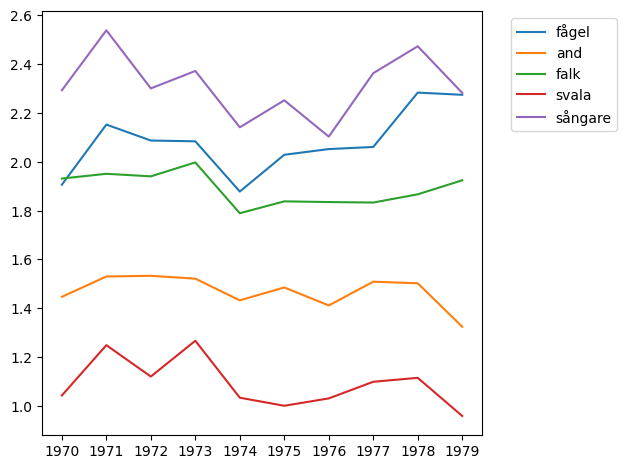

In [57]:
tmp = 0

for bird, freq in frequency.items():
  tmp +=1
  onlyFreqs = {}
  avg = 0
  for f in freq:
    onlyFreqs.update({str(f): freq[f]["freq"]})
    avg += freq[f]["freq"]/10
  if avg > 1:
    plt.plot(onlyFreqs.keys(), onlyFreqs.values(), label=bird)



plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()


In [138]:
wordSearches = ["Stockholm", "Göteborg", "morgon", "natt", "skola", "land", "hafvet"]

In [140]:
print("bird\t| Stockholm \t| Göteborg \t| morgon \t| natt \t| skola | land \t| hafvet \t|")
for bird, freq in frequency.items():
  srt = {k: v for k, v in sorted(freq.items(), key=lambda item: item[0])}
  if frequency[bird]["1925"]["freq"] > 0.25:
    wordCounts = [0,0,0,0,0,0,0]
    for i,ws in enumerate(wordSearches):
      try:
        wordCounts[i] = cooccurenceMatrix[bird].get(ws)
      except:
        wordCounts[i] = 0
      
    printString = "{}\t| {} \t\t| {} \t\t| {} \t\t| {} \t| {} \t| {} \t| {} \t\t|".format(bird, wordCounts[0],wordCounts[1],wordCounts[2],wordCounts[3],wordCounts[4],wordCounts[5],wordCounts[6])
    print(printString)

bird	| Stockholm 	| Göteborg 	| morgon 	| natt 	| skola | land 	| hafvet 	|
fågel	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|
ejder	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|
gråsparv	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|
järpe	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|
morkulla	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|
orre	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|
råka	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|
stare	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|
svärta	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|
tjäder	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|


In [ ]:
sortCooccurence(cooccurenceMatrix["Korp"])

[('och', 6010),
 ('i', 5459),
 ('af', 3835),
 ('att', 3222),
 ('till', 2564),
 ('en', 2559),
 ('den', 2446),
 ('som', 2336),
 ('för', 2257),
 ('med', 1877),
 ('på', 1834),
 ('det', 1521),
 ('de', 1471),
 ('—', 1275),
 ('är', 1159),
 ('ett', 1148),
 ('sig', 1043),
 ('vid', 1038),
 ('har', 997),
 ('om', 963),
 ('från', 861),
 ('han', 823),
 ('m', 691),
 ('å', 675),
 ('man', 660),
 ('under', 630),
 ('var', 598),
 ('ej', 581),
 ('I', 562),
 ('så', 540),
 ('samt', 526),
 ('kr', 520),
 ('kl', 502),
 ('1', 496),
 ('icke', 493),
 ('sin', 490),
 ('A', 459),
 ('år', 429),
 ('då', 427),
 ('hade', 427),
 ('skulle', 393),
 ('nu', 390),
 ('där', 389),
 ('men', 387),
 ('jag', 385),
 ('ha', 366),
 ('Det', 363),
 ('denna', 348),
 ('eller', 345),
 ('andra', 340),
 ('efter', 335),
 ('vi', 331),
 ('e', 327),
 ('än', 325),
 ('mot', 313),
 ('Den', 312),
 ('öfver', 308),
 ('äro', 297),
 ('hans', 296),
 ('genom', 294),
 ('Stockholm', 292),
 ('äfven', 286),
 ('En', 286),
 ('detta', 284),
 ('dag', 282),
 ('alla